In this notebook, we want to predict gene regulatory factors relative to the healthy single-cell reference, that improve deconvolution performance. Therefore we apply module 3 with the hyperparameters we found in `05b_Hyperparameter_Search.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import deconomix as dcx

In [4]:
PREFIX = '05c_'

# Hyperparameters
l2_LumA  = 1e-8
l2_LumB  = 1e-10
l2_Her2  = 1e-07
l2_Basal = 1e-07

# DISCO Healthy reference + training data
X_ref = pd.read_pickle('../Data/Preprocessed/X_ref.pkl').astype(np.float64)
Y_train = pd.read_pickle('../Data/Preprocessed/Y_train.pkl').astype(np.float64)
C_train = pd.read_pickle('../Data/Preprocessed/C_train.pkl').astype(np.float64)

# TCGA bulk data + subtypes
tcga_bulks = pd.read_pickle('../Data/Preprocessed/tcga_conv_norm.pkl').astype(np.float64)
tcga_subtypes = pd.read_csv('../Data/Preprocessed/tcga_subtype.csv').values.flatten()

tcga_LumA = tcga_bulks.iloc[:, tcga_subtypes == "LumA"]
tcga_LumB = tcga_bulks.iloc[:, tcga_subtypes == "LumB"]
tcga_Her2 = tcga_bulks.iloc[:, tcga_subtypes == "Her2"]
tcga_Basal = tcga_bulks.iloc[:, tcga_subtypes == "Basal"]

  0%|          | 0/1000 [00:00<?, ?it/s]

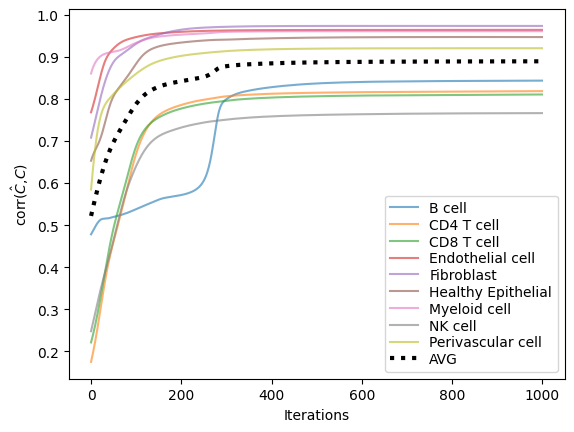

In [5]:
#Train a DTD model on DISCO Healthy reference
model_DTD = dcx.methods.DTD(X_ref, Y_train, C_train,)
model_DTD.run(plot=True)

In [ ]:
# Apply ADTD with Delta for all subtypes
for subtype_name, tcga_data, l2 in [
    ("LumA", tcga_LumA, l2_LumA),
    ("LumB", tcga_LumB, l2_LumB),
    ("Her2", tcga_Her2, l2_Her2),
    ("Basal", tcga_Basal, l2_Basal),
]:
    model_ADTD = dcx.methods.ADTD(X_ref, tcga_data, model_DTD.gamma, C_static=True, Delta_static=False, lambda2=l2)
    model_ADTD.run()
    C_est = model_ADTD.C_est
    C_est.columns = tcga_data.columns
    c_est = model_ADTD.c_est
    c_est.columns = tcga_data.columns
    x_est = model_ADTD.x_est
    Delta = pd.DataFrame(model_ADTD.Delta, columns=X_ref.columns, index=X_ref.index)
    C_est.to_csv(f"../Outputs/{PREFIX}C_est_{subtype_name}.csv")
    c_est.to_csv(f"../Outputs/{PREFIX}c_est_{subtype_name}.csv")
    Delta.to_csv(f"../Outputs/{PREFIX}Delta_est_{subtype_name}.csv")
    x_est.to_csv(f"../Outputs/{PREFIX}x_est_{subtype_name}.csv")
